# CatFusion: Diffusion model for generating cat images

# loading the dataset

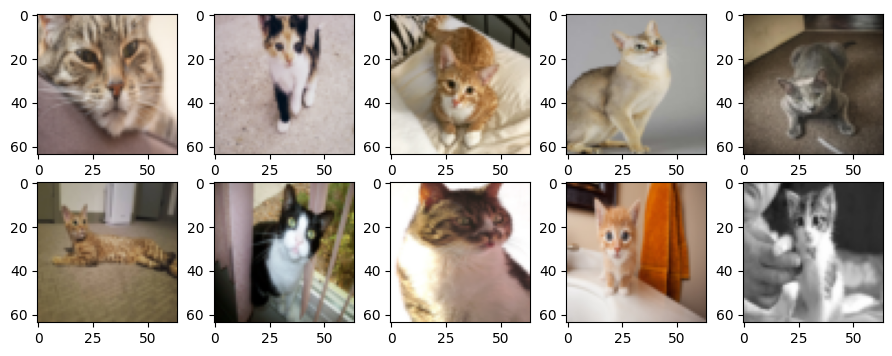

In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

dataset = torch.load("datasets/cats.pth")

to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(11, 4))

columns = 5
rows = 2

for i in range(1,rows*columns + 1):
    fig.add_subplot(rows, columns, i)
    image, _ = dataset[i]
    plt.imshow(to_pil(image))

plt.show()

## Noise scheduler

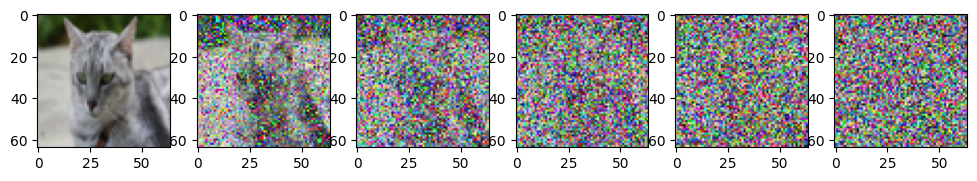

In [2]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from noise_scheduler import add_noise

columns = 6
rows = 1
to_pil = transforms.ToPILImage()

fig = plt.figure(figsize=(12, 3))

dataset = torch.load("datasets/cats.pth")
#data, _ = dataset[5]

def get_timestep(data, timestep):
    data = add_noise(data, torch.tensor(timestep), torch.tensor(1000))
    image = to_pil(data)
    return image

for i in range(1,rows*columns + 1):
    fig.add_subplot(rows, columns, i)
    data, _ = dataset[20]
    plt.imshow(get_timestep(data,200 * (i-1)))

plt.show()


## Backward process (Denoising)

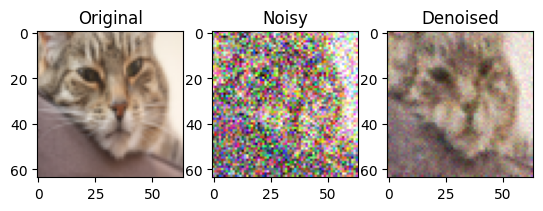

In [1]:
from test_single_datapoint import test_model
test_model(verbose=False)

Training

iteration 0:


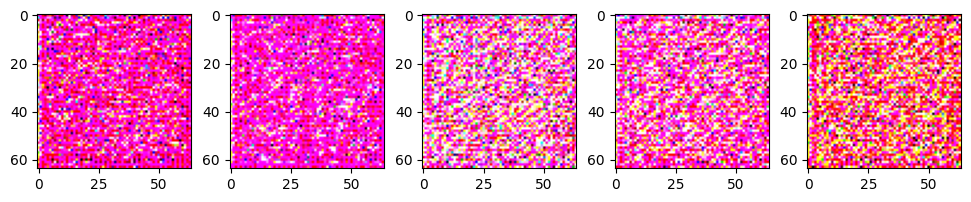

iteration 30:


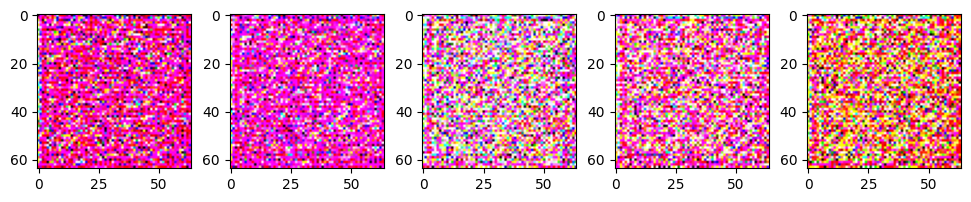

iteration 60:


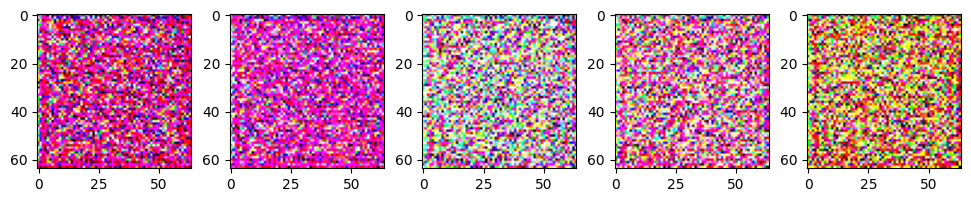

iteration 90:


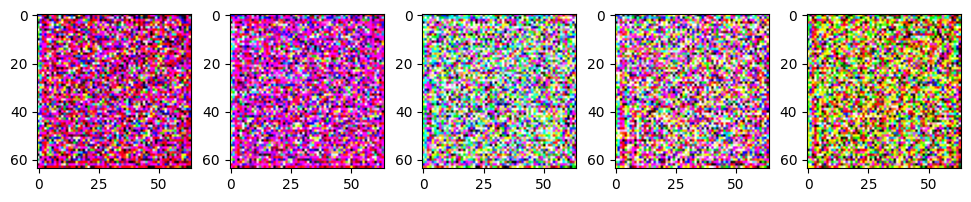

iteration 120:


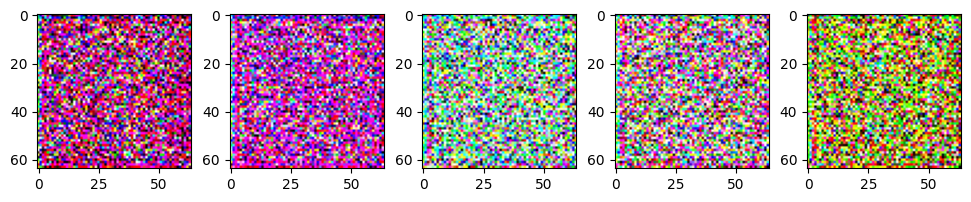

iteration 150:


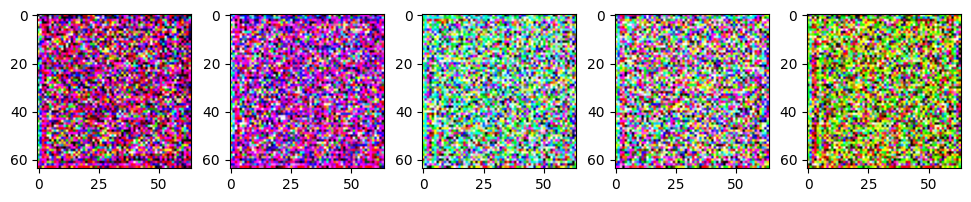

iteration 180:


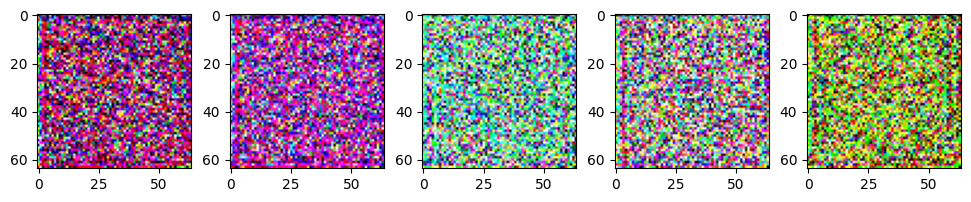

iteration 210:


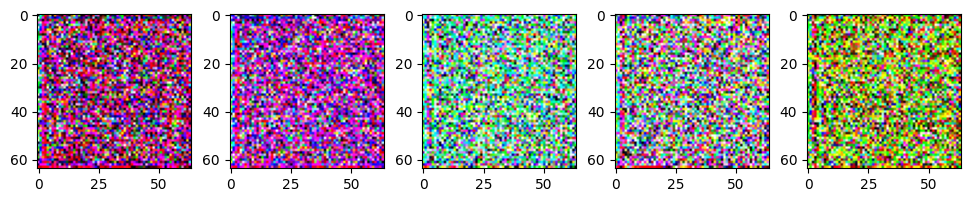

iteration 240:


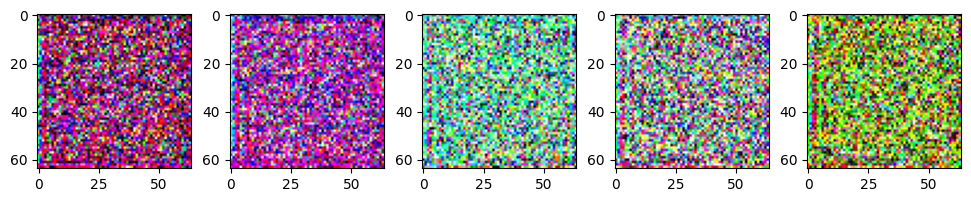

iteration 270:


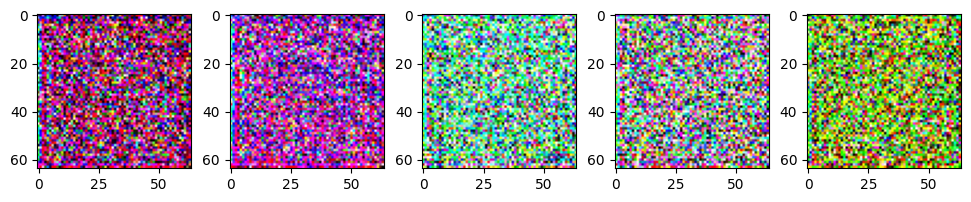

final image


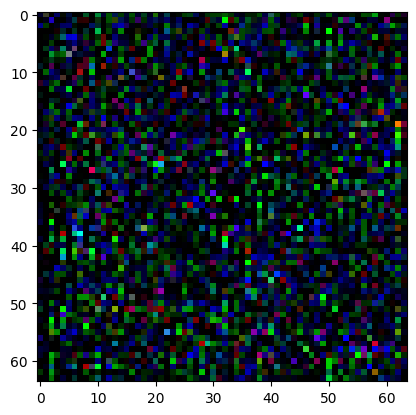

In [7]:
import torch
from torchvision import transforms
import torchvision
from model import DiffusionModel
import matplotlib.pyplot as plt
from train import train_sample, denoise_timestep

import gc

device = "cuda"

TOTAL_TIMESTEPS = 100
EPOCHS = 300

dataset = torch.load("datasets/cats.pth")
dataset = torch.utils.data.Subset(dataset, range(1))

model = DiffusionModel(device=device)
model = model.to(device)

to_pil = transforms.ToPILImage()


def show_process_plot(model):
    model_process_images = []
    noise = torch.randn_like(dataset[0][0]).unsqueeze(0)
    noise = noise.to(device)
    fig = plt.figure(figsize=(12, 2))
    for t in range(0,TOTAL_TIMESTEPS)[::-1]:
        t = torch.tensor(t).to(device)
        noise = denoise_timestep(model, noise, t, TOTAL_TIMESTEPS, device=device)
        #added_noise = model(noise, t)
        if t % 20 == 0:
            img = to_pil(noise.squeeze(0))
            model_process_images.append(img)
    
    for i in range(len(model_process_images)):
        fig.add_subplot(1, 5, i + 1)
        plt.imshow(model_process_images[i])
    plt.show()
    


for epoch in range(EPOCHS):
    for i, (data,_) in enumerate(dataset):
        model = train_sample(model, data.to(device), TOTAL_TIMESTEPS, device=device)
        gc.collect()
        torch.cuda.empty_cache()
        if i % 200 == 0:
            #print(f"iteration {i + (len(dataset) * epoch)}:")
            #show_process_plot(model)
            pass
    if epoch % 30 == 0:
        print(f"iteration {i + (len(dataset) * epoch)}:")
        show_process_plot(model)
    model.save()


noise = torch.randn_like(dataset[0][0]).unsqueeze(0)
noise = noise.to(device)


for t in range(TOTAL_TIMESTEPS):
    noise = model(noise, torch.tensor(t).to(device))
    noise = torch.clamp(noise, 0, 1)
    gc.collect()
    torch.cuda.empty_cache()
    noise = noise.clone().detach()

img = to_pil(noise.squeeze(0))

plt.imshow(img)
print("final image")
plt.show()

model.save()
